# Plots related to timeshift analysis

Some simple figures for timeshifts across different regions and subregions.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
import scipy.io as spio
from scipy import stats
import pandas as pd
import pickle

import local_env
import VideoAnalysisUtils.functions as func

In [2]:
figfolder = '../figs/timeshift/'
datafolder = '../data/'

os.makedirs(os.path.abspath(figfolder), exist_ok=True)

In [3]:
allen_hierarchy_name = 'mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx'

df = pd.read_excel(datafolder + allen_hierarchy_name,engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)


#r2_new = pickle.load(open(datafolder + 'r2_data_dict_smallwindows_v3.pkl', 'rb'))
r2_new = pickle.load(open(datafolder + 'r2_data_dict_expanded_smallwindow_subtract_pertimeavg.pkl', 'rb'))


ccf_labels = r2_new['5_0']['ccf_labels'].copy()
ccf_coords = r2_new['5_0']['ccf_coords'].copy()
is_alm = r2_new['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]
areas = ['Medulla','Midbrain', 'ALM', 'Striatum', 'Thalamus']

epochs = ['sample','delay','response']
r2_methods = ['old', 'old_clipped', 'new']

method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}

In [4]:
timeshifts = np.arange(-30,32,2, dtype = int)

In [5]:
r2_new['5_0'].keys()

dict_keys(['sample_r2', 'delay_r2', 'response_r2', 'sample_r2_old', 'delay_r2_old', 'response_r2_old', 'session_name', 'ccf_coords', 'ccf_labels', 'sample_fr', 'delay_fr', 'response_fr', 'is_alm', 'avg_fr', 'mean_corr_fr', 'trial_to_trial_var', 'sample_r2_shifted', 'delay_r2_shifted', 'response_r2_shifted', 'sample_r2_shifted_old', 'delay_r2_shifted_old', 'response_r2_shifted_old'])

## Functions

In [6]:
def get_single_area_inds(area, df, ccf_labels):
    subregion_labels = func.get_all_subregion_annotations_from_name(df, area)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, {area: subregion_labels})
    return inds[area]

def get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds):
    subregions_annotation_dict = dict()
    for subreg in region_list:
        if subreg == 'ALM':
            continue
        else:
            subregions_annotation_dict[subreg] = func.get_all_subregion_annotations_from_name(df, subreg)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, subregions_annotation_dict)

    if 'ALM' in region_list:
        use_inds = dict()
        use_inds['ALM'] = alm_inds
        for k,v in inds.items():
            use_inds[k] = np.setdiff1d(v, alm_inds)
        
        return use_inds
    
    return inds

## Plots

### Normalized per-area curves

In [ ]:
r2_threshold = .01
fr_threshold = 2.

epoch = 'response'
r2_method = 'new'

fr = r2_new['5_0']['avg_fr'].copy()
r2 = []

for timesh in timeshifts:
    r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch,method_to_string[r2_method])].copy())

r2 = np.array(r2)
# there are no negative values in the new method
#r2[r2<0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)

best_times = 3.4 * timeshifts[r2.argmax(axis = 0)]
area_colors = ['b', 'k', 'g', 'c', 'y']
k = 4

k_r2_diff = r2[np.where(timeshifts == k)[0][0],:] - r2[np.where(timeshifts == -k)[0][0],:]

area_inds = {}
for j, area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds
    else:
        inds = get_single_area_inds(area, df, ccf_labels)

    inds = np.intersect1d(inds, threshold_inds)
    area_inds[area] = inds

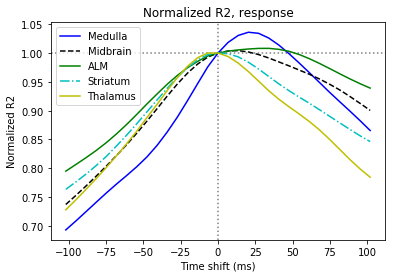

In [32]:
lines_colors = ['b-', 'k--', 'g-', 'c-.', 'y-']
for j, area in enumerate(areas):

    avg_r2 = r2[:,area_inds[area]].mean(axis = 1)
    plt.plot(timeshifts*3.4, avg_r2/avg_r2[np.where(timeshifts == 0)[0][0]],lines_colors[j], label = area)

a,b = plt.xlim()
plt.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
plt.xlim(a,b)

a,b = plt.ylim()
plt.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
plt.ylim(a,b)

plt.xlabel('Time shift (ms)')
plt.ylabel('Normalized R2')
plt.legend()
plt.title('Normalized R2, %s'%epoch)
plt.savefig(figfolder + 'normalized_r2_%s.png'%epoch, dpi = 200)

### Histograms

#### Overall distribution of timeshifts

In [62]:
r2_threshold = .01
fr_threshold = 2.

epoch = 'response'
r2_method = 'new'

fr = r2_new['5_0']['avg_fr'].copy()
r2 = []

for timesh in timeshifts:
    r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch,method_to_string[r2_method])].copy())

r2 = np.array(r2)
# there are no negative values in the new method
#r2[r2<0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)

best_times = 3.4 * timeshifts[r2.argmax(axis = 0)]
area_colors = ['b', 'k', 'g', 'c', 'y']
k = 4

k_r2_diff = r2[np.where(timeshifts == k)[0][0],:] - r2[np.where(timeshifts == -k)[0][0],:]

area_inds = {}
for j, area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds
    else:
        inds = get_single_area_inds(area, df, ccf_labels)

    inds = np.intersect1d(inds, threshold_inds)
    area_inds[area] = inds

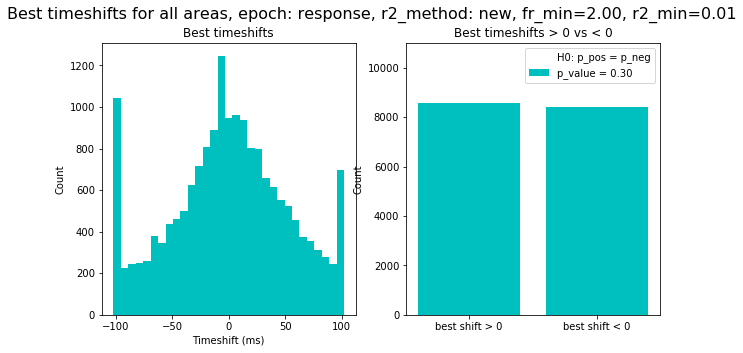

In [63]:
f,_ = plt.subplots(1,2, figsize = (10,5))
f.suptitle('Best timeshifts for all areas, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold), fontsize = 16)

plt.subplot(1,2,1)
plt.hist(best_times[threshold_inds], bins = 31, color = 'c')
plt.title('Best timeshifts')
plt.xlabel('Timeshift (ms)')
plt.ylabel('Count')

plt.subplot(1,2,2)
n_pos = np.sum(best_times[threshold_inds] > 0)
n_neg = np.sum(best_times[threshold_inds] < 0)
p_value = stats.binom_test([n_pos, n_neg], n = n_pos + n_neg, p = .5)
plt.plot([],[],' ', label = 'H0: p_pos = p_neg')
plt.bar(['best shift > 0', 'best shift < 0'], [np.sum(best_times[threshold_inds] > 0), np.sum(best_times[threshold_inds] < 0)], color = 'c', label = 'p_value = %.2f'%p_value)

plt.legend()
plt.ylabel('Count')
plt.ylim(0,11000)
plt.title('Best timeshifts > 0 vs < 0')

plt.savefig(figfolder + 'best_timeshifts_allneurons_%s_%s_frmin%.2f_r2min%.2f.png'%(epoch,r2_method,fr_threshold,r2_threshold))

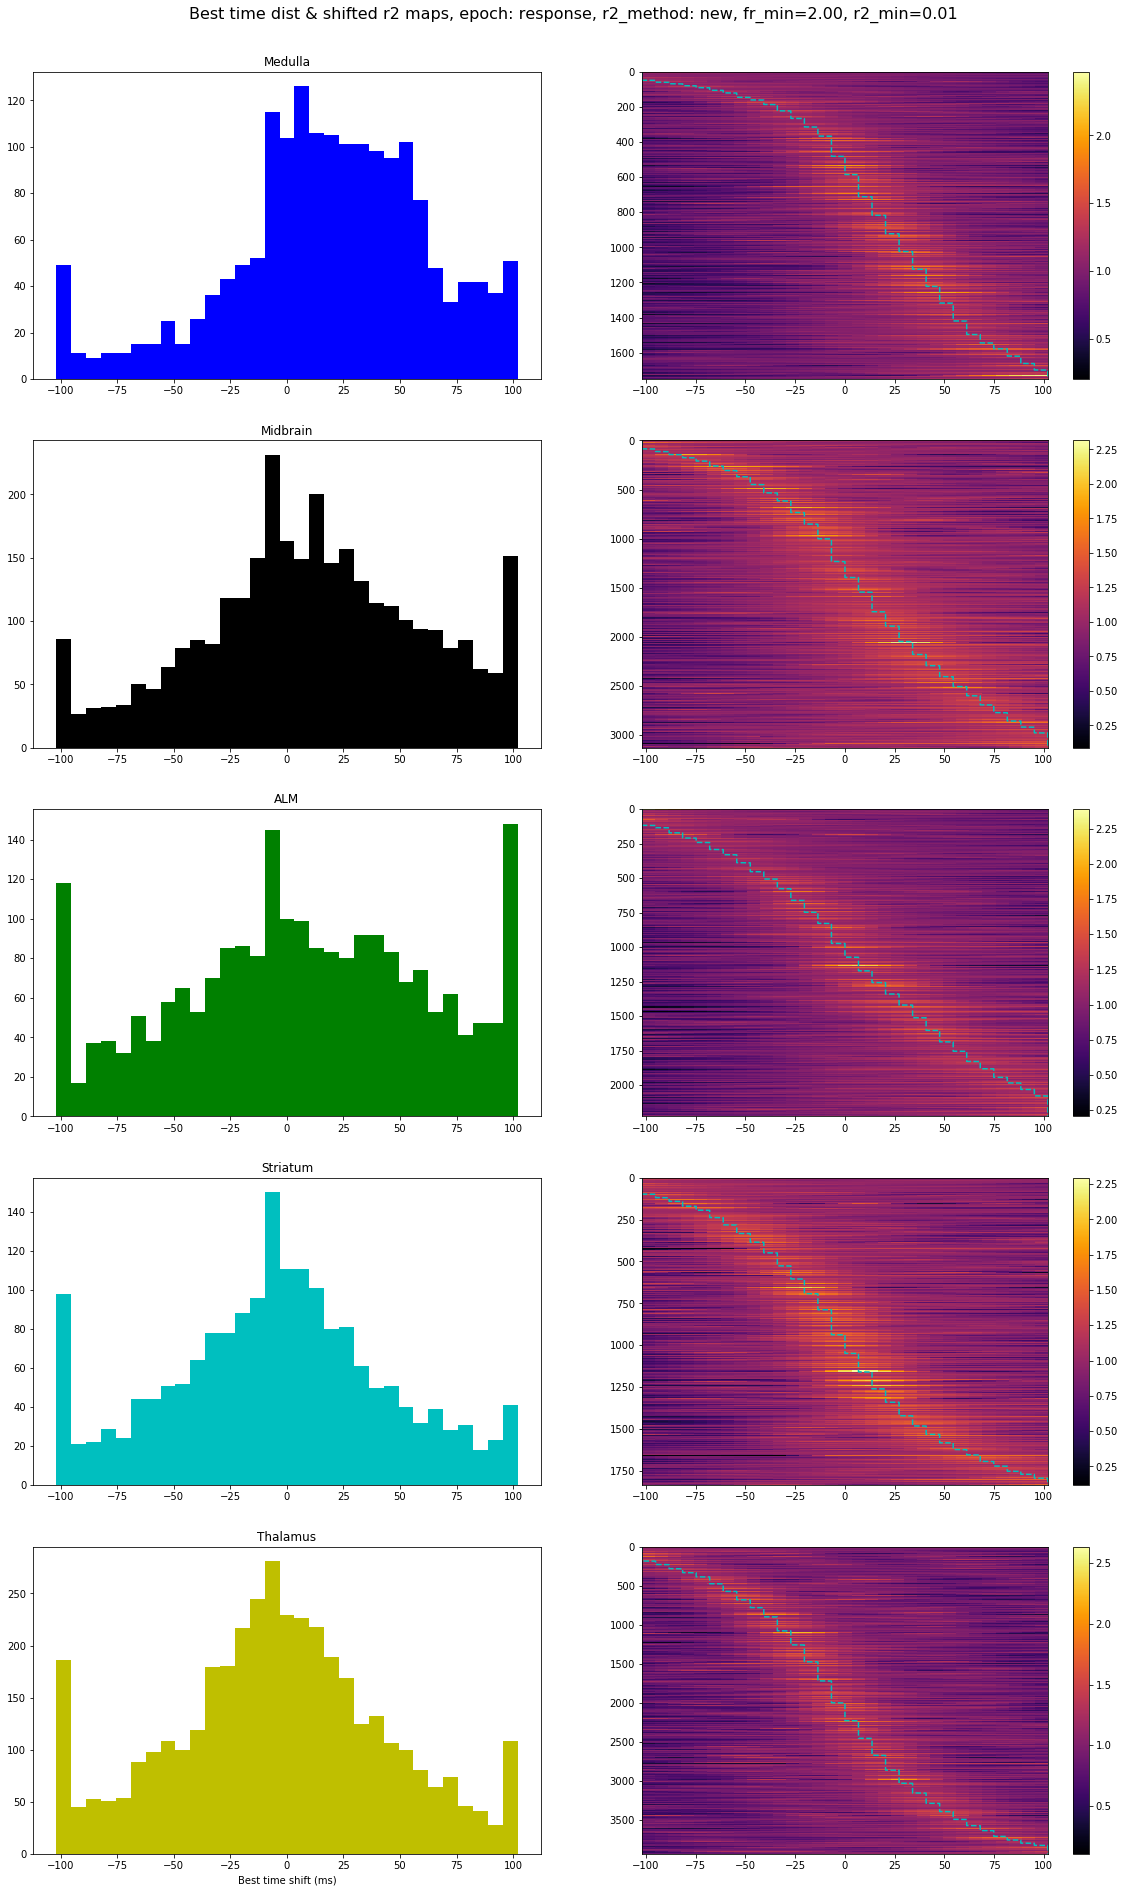

In [64]:
f,_ = plt.subplots(5,2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold), fontsize = 16)
for i, area in enumerate(areas):
    plt.subplot(5,2,2*i+1)
    n_pos = np.sum(best_times[area_inds[area]] > 0)
    n_neg = np.sum(best_times[area_inds[area]] < 0)
    p_value = stats.binom_test([n_pos, n_neg], n = n_pos + n_neg, p = .5)
    plt.hist(best_times[area_inds[area]], bins = 31, color = area_colors[i], label = 'p_value = %.4f'%p_value)
    #plt.legend()
    plt.title(area)
    if i == 4: plt.xlabel('Best time shift (ms)')

    plt.subplot(5,2,2*i+2)
    _area_shifted_r2 = r2[:,area_inds[area]]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)

    plt.imshow(_area_shifted_r2[:,_area_sortinds].T / _area_shifted_r2[:,_area_sortinds].T.mean(axis = 1, keepdims = True), aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'best_timeshifts_bigregions_%s_%s_frmin%.2f_r2min%.2f.png'%(epoch,r2_method,fr_threshold,r2_threshold))

#### Thalamus nuclei

In [65]:
thalamus_use_nuclei = [
    'Anteromedial nucleus', #AN
    'Central medial nucleus of the thalamus', #CN
    'Mediodorsal nucleus of thalamus', #MD
    'Medial geniculate complex', #MGN
    'Paracentral nucleus', #PC
    'Parafascicular nucleus', #PF
    'Posterior complex of the thalamus', #PO
    'Paraventricular nucleus of the thalamus', #PVN
    'Reticular nucleus of the thalamus', #RT
    'Submedial nucleus of the thalamus', #SMN
    'Ventral anterior-lateral complex of the thalamus', #VAL
    'Ventral medial nucleus of the thalamus', #VM
    'Ventral posteromedial nucleus of the thalamus', #VPN
]

short_names = [
    'AN',
    'CN',
    'MD',
    'MGN',
    'PC',
    'PF',
    'PO',
    'PVN',
    'RT',
    'SMN',
    'VAL',
    'VM',
    'VPN',
]

short_names_correct_allen = [
    'AM',
    'CM',
    'MD',
    'MG',
    'PCN',
    'PF',
    'PO',
    'PVT',
    'RT',
    'SMT',
    'VAL',
    'VM',
    'VPM',    
]

cc = [
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",     # A bright red-orange
    "coral",      # A soft, pinkish-orange
    "lavender",   # A soft, light purple
    "plum",       # A dark, rich purple
    "beige",      # A soft, pale sandy color
    "sienna",     # A reddish-brown earth tone
    "teal"        # A medium blue-green color
]

In [66]:
region_list = thalamus_use_nuclei
n_min = 100

inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
use_inds = {k: np.intersect1d(v,threshold_inds) for k,v in inds.items() if np.intersect1d(v,threshold_inds).shape[0] > n_min}

<ipython-input-67-3f6d17ba3c33>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


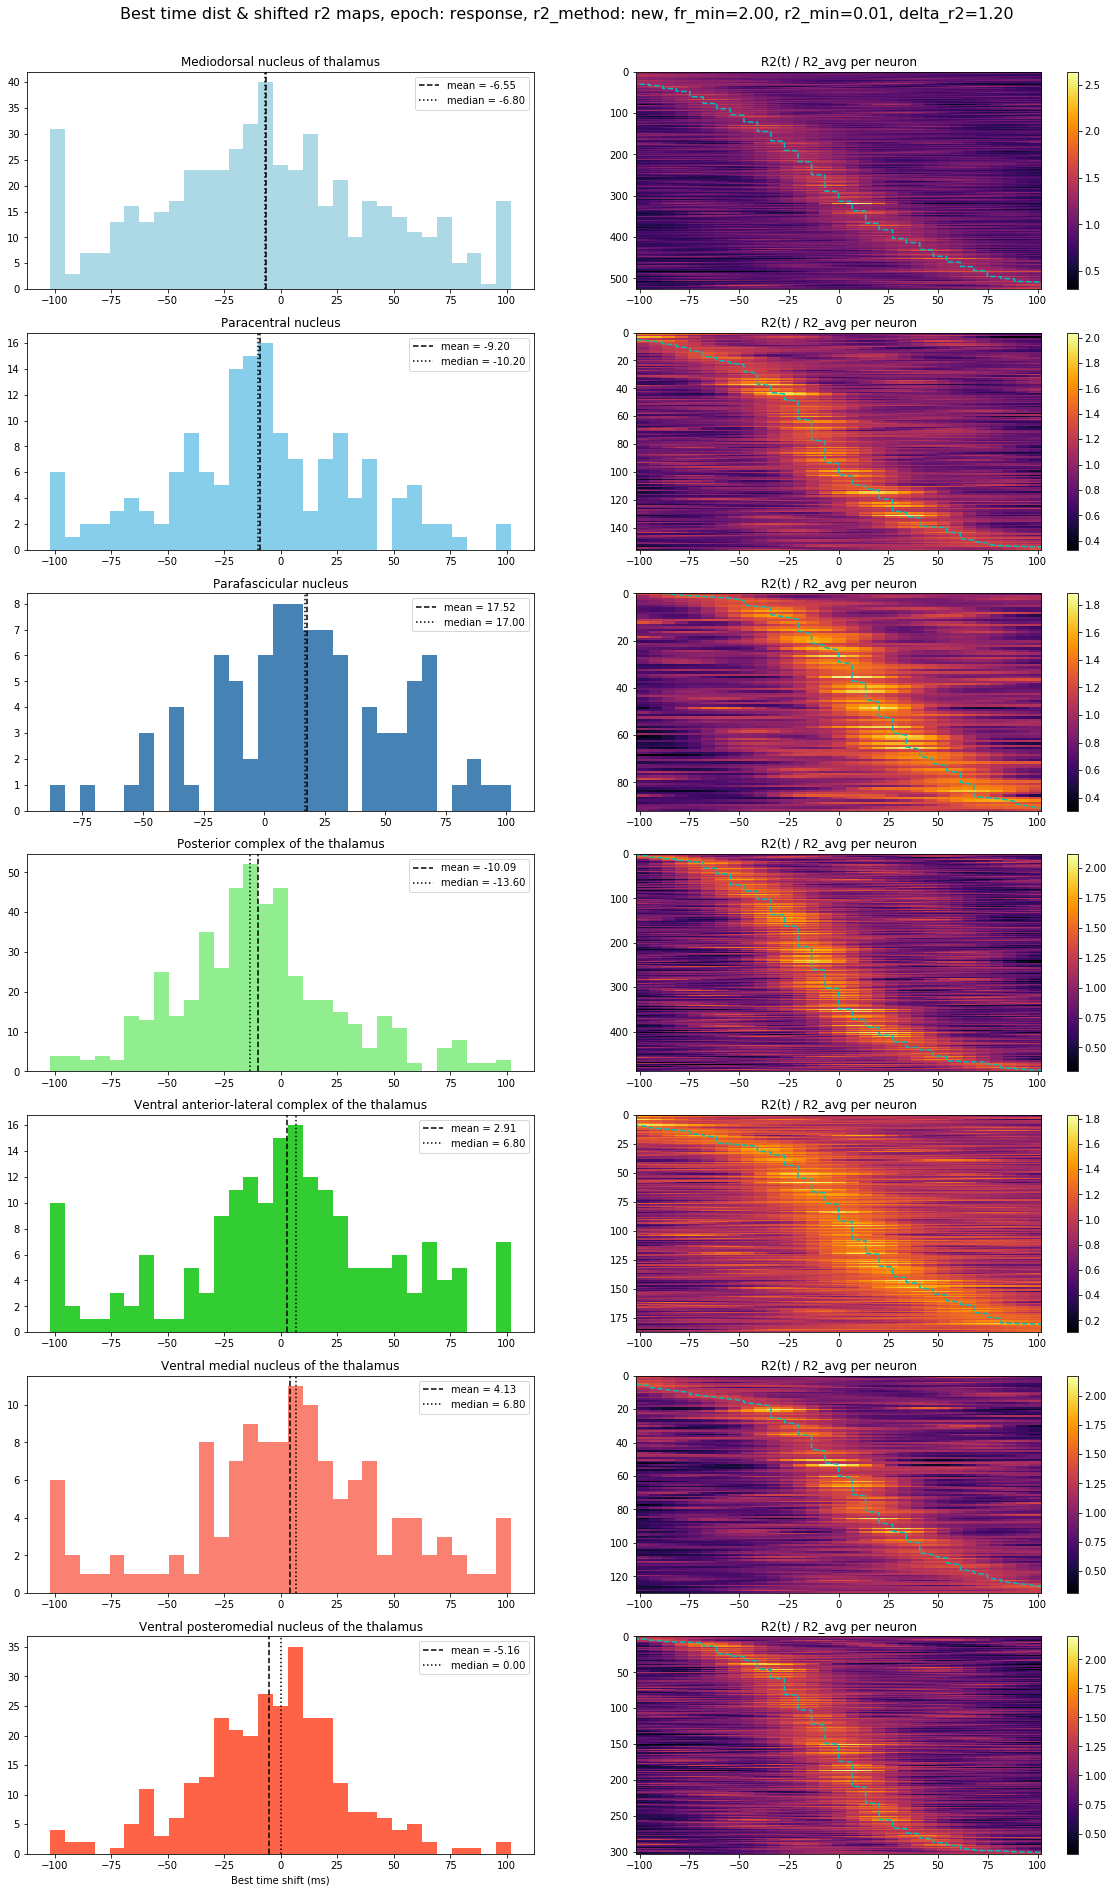

In [67]:
delta_r2 = 1.2

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    _mean = best_times[_this_inds].mean()
    _meadian = np.median(best_times[_this_inds])
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    a,b = plt.ylim()
    plt.plot([_mean, _mean], [a,b], 'k--', label = 'mean = %.2f'%_mean)
    plt.plot([_meadian, _meadian], [a,b], 'k:', label = 'median = %.2f'%_meadian)
    plt.ylim(a,b)
    plt.title(area)
    plt.legend()
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'thalamus_best_time_dist_and_r2_maps_%s_%s_frmin%.2f_r2min%.2f.png'%(epoch,r2_method,fr_threshold,r2_threshold), bbox_inches = 'tight')

#### Cortical subregions

In [68]:
use_cortex_list = ['ALM',
                   'Somatosensory areas',
                   'Somatomotor areas',
                   'Auditory areas',
                   'Orbital area',
                   'Agranular insular area',
                   'Retrosplenial area',]

col_list = [
    "lightblue",    # Some kind of blue
    "skyblue",      # Some kind of blue
    "steelblue",    # Some kind of blue
    "lightgreen",   # Some kind of green
    "limegreen",    # Some kind of green
    "salmon",
    "tomato",
    "coral"
]

short_cortex_names = [
    'ALM',
    'Somatosensory',
    'Somatomotor',
    'Auditory',
    'Orbital',
    'Angular',
    'Retrosplenial',
]

In [69]:
region_list = use_cortex_list
n_min = 100

inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
use_inds = {k: np.intersect1d(v,threshold_inds) for k,v in inds.items() if np.intersect1d(v,threshold_inds).shape[0] > n_min}

<ipython-input-70-e1bc81c3dd2a>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


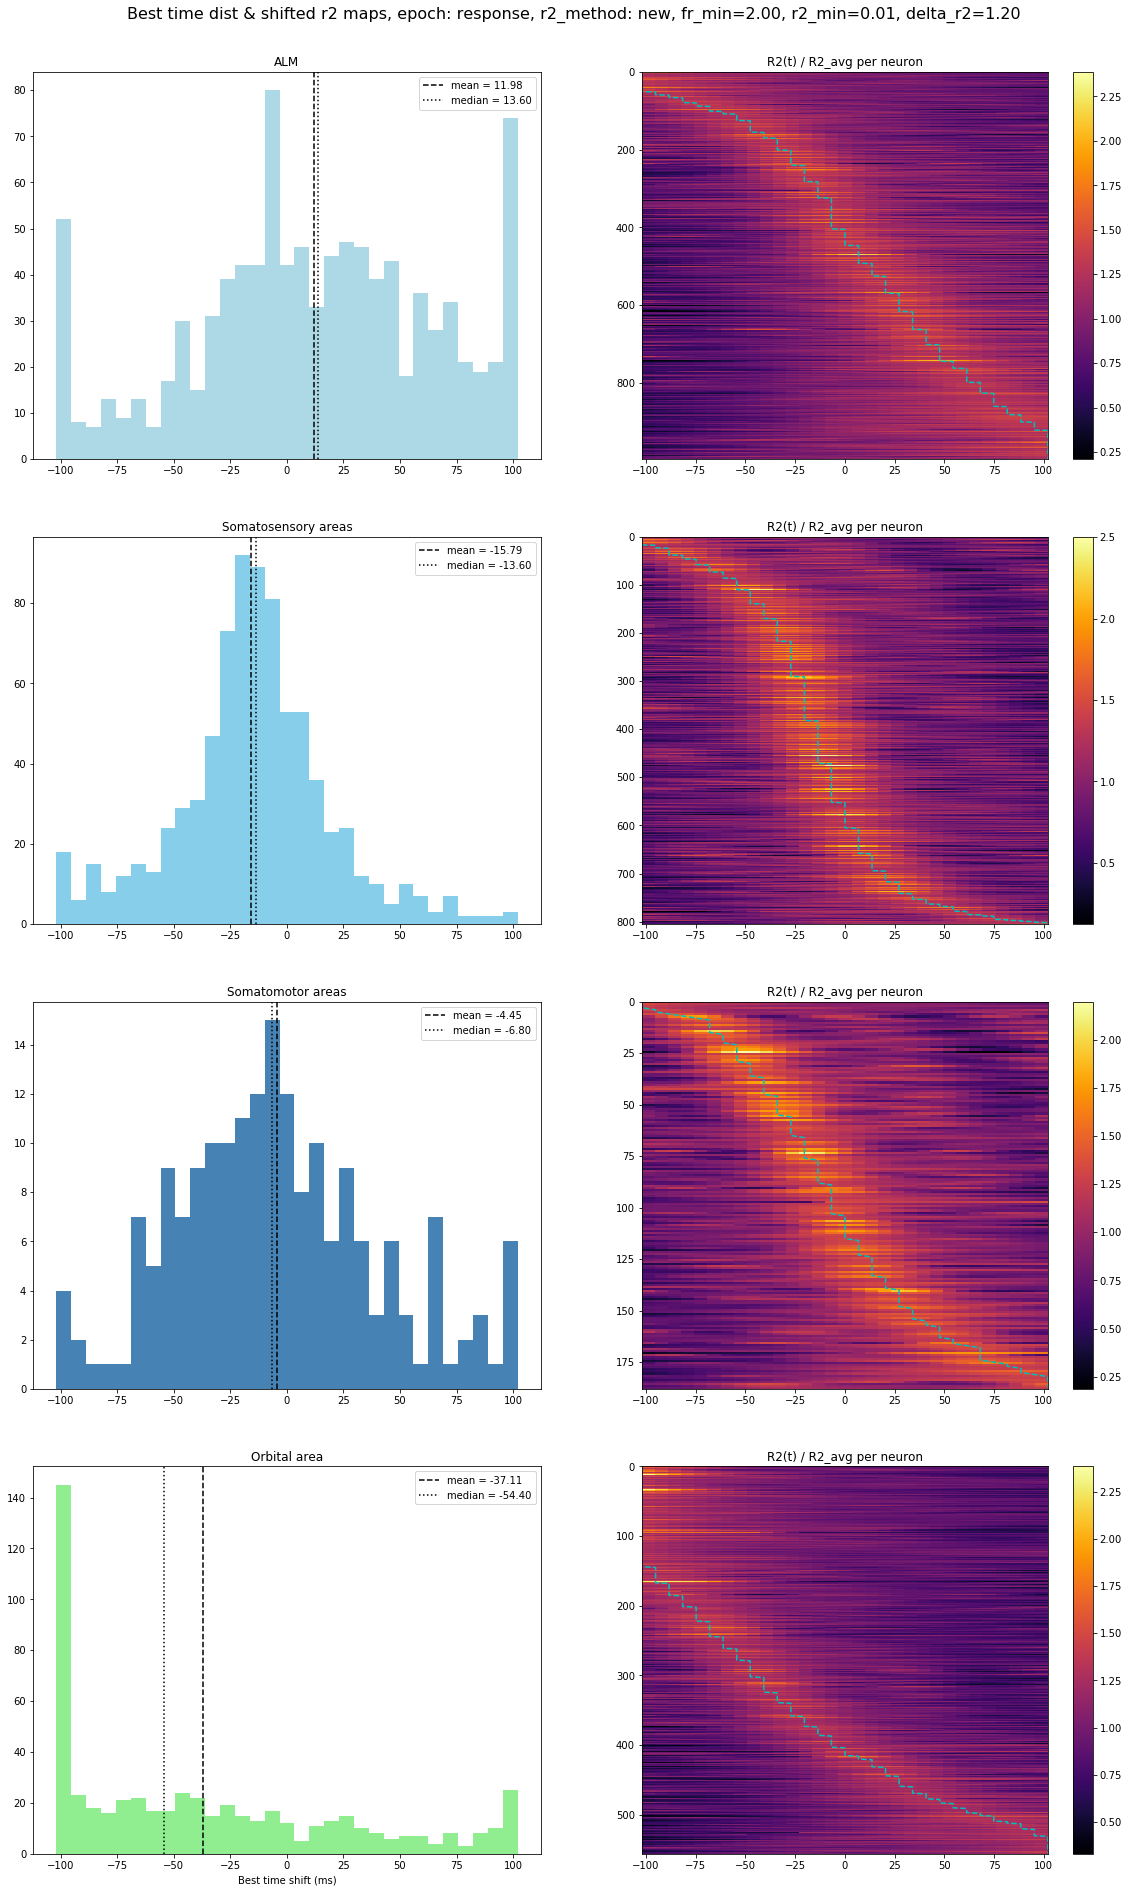

In [70]:
delta_r2 = 1.2

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    _mean = best_times[_this_inds].mean()
    _meadian = np.median(best_times[_this_inds])
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    a,b = plt.ylim()
    plt.plot([_mean, _mean], [a,b], 'k--', label = 'mean = %.2f'%_mean)
    plt.plot([_meadian, _meadian], [a,b], 'k:', label = 'median = %.2f'%_meadian)
    plt.ylim(a,b)
    plt.title(area)
    plt.legend()
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'cortex_best_time_dist_and_r2_maps_%s_%s_frmin%.2f_r2min%.2f.png'%(epoch,r2_method,fr_threshold,r2_threshold), bbox_inches = 'tight')

#### Cosmetics

In [71]:
use_cortex_list = ['ALM',
                   'Somatosensory areas',
                   'Somatomotor areas',
                   #'Auditory areas',
                   #'Orbital area',
                   #'Agranular insular area',
                   #'Retrosplenial area',
                   ]

col_list = [
    "lightblue",    # Some kind of blue
    "skyblue",      # Some kind of blue
    "steelblue",    # Some kind of blue
    "lightgreen",   # Some kind of green
    "limegreen",    # Some kind of green
    "salmon",
    "tomato",
    "coral"
]

short_cortex_names = [
    'ALM',
    'Somatosensory',
    'Somatomotor',
    #'Auditory',
    #'Orbital',
    #'Angular',
    #'Retrosplenial',
]

In [72]:
region_list = use_cortex_list
n_min = 100

inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
use_inds = {k: np.intersect1d(v,threshold_inds) for k,v in inds.items() if np.intersect1d(v,threshold_inds).shape[0] > n_min}

<ipython-input-73-9a52110f4d4d>:4: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


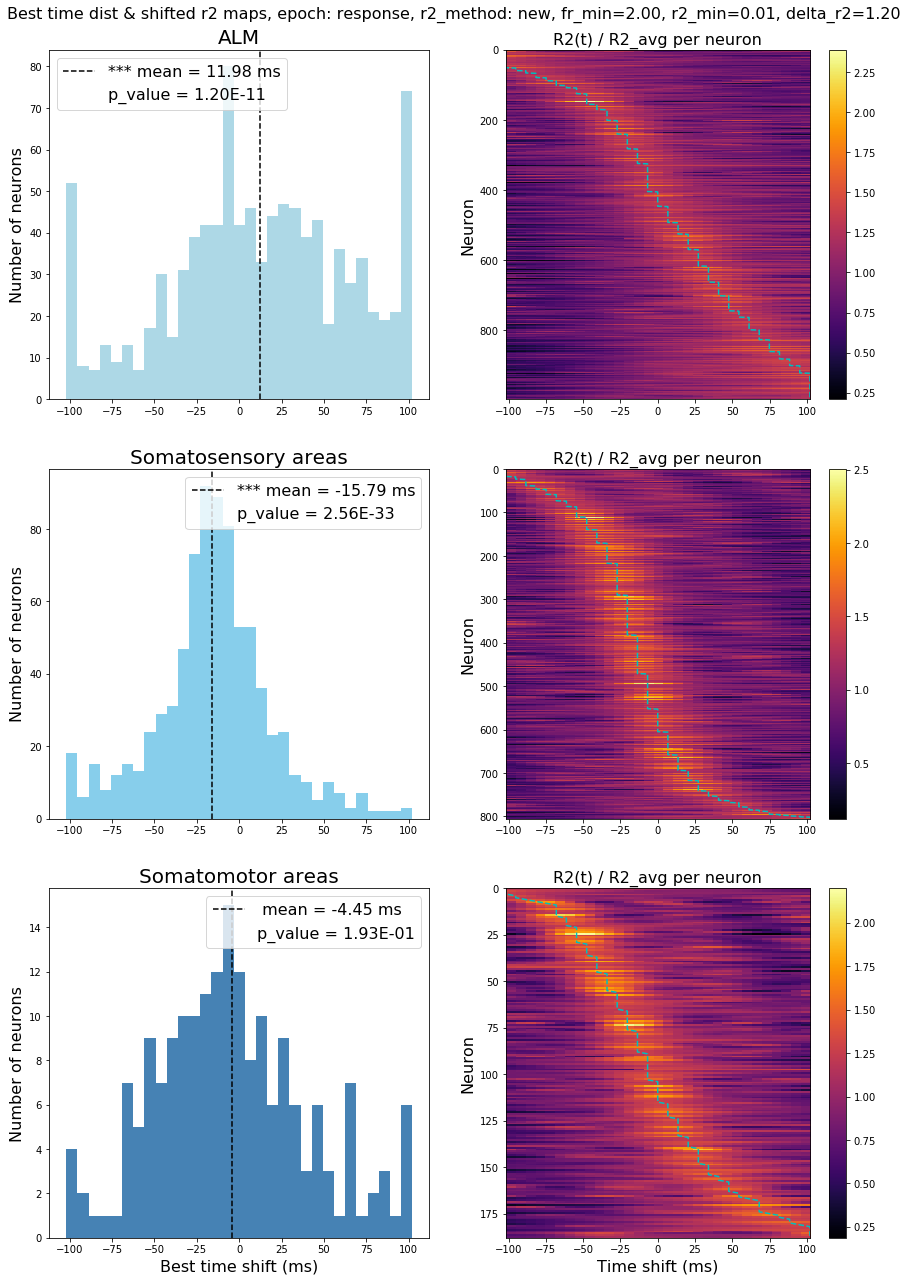

In [73]:
delta_r2 = 1.2
from scipy.stats import ttest_1samp

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (15,20))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    _mean = best_times[_this_inds].mean()
    _meadian = np.median(best_times[_this_inds])
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    a,b = plt.ylim()
    t_stat, p_value = ttest_1samp(best_times[_this_inds], 0)
    significance_str = '***' if p_value < .001 else '**' if p_value < .01 else '*' if p_value < .05 else ''
    plt.plot([_mean, _mean], [a,b], 'k--', label = '%s mean = %.2f ms'%(significance_str,_mean))
    plt.plot([],[],' ', label = 'p_value = %.2E'%p_value)
    #plt.plot([_meadian, _meadian], [a,b], 'k:', label = 'median = %.2f ms'%_meadian)
    plt.ylim(a,b)
    plt.ylabel('Number of neurons', fontsize = 16)
    plt.title(area, fontsize = 20)
    plt.legend(fontsize = 16)
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)', fontsize = 16)

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron', fontsize = 16)
    plt.ylabel('Neuron', fontsize = 16)
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Time shift (ms)', fontsize = 16)

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'cortex_best_time_dist_and_r2_maps_%s_%s_frmin%.2f_r2min%.2f_nice_plot.png'%(epoch,r2_method,fr_threshold,r2_threshold), bbox_inches = 'tight', dpi = 300)

#### Medulla

In [74]:
medulla_use_nuclei = [
    'Medulla, sensory related',
    'Gigantocellular reticular nucleus',
    'Intermediate reticular nucleus',
    'Magnocellular reticular nucleus',
    'Parvicellular reticular nucleus',
    'Vestibular nuclei',
]

medulla_short_names = [
    'Sensory medulla',
    'Gigantocellular',
    'Intermediate',
    'Magnocellular',
    'Parvicellular',
    'Vestibular'
]

In [75]:
region_list = medulla_use_nuclei
n_min = 100

inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
use_inds = {k: np.intersect1d(v,threshold_inds) for k,v in inds.items() if np.intersect1d(v,threshold_inds).shape[0] > n_min}

<ipython-input-76-891c7728a0c3>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


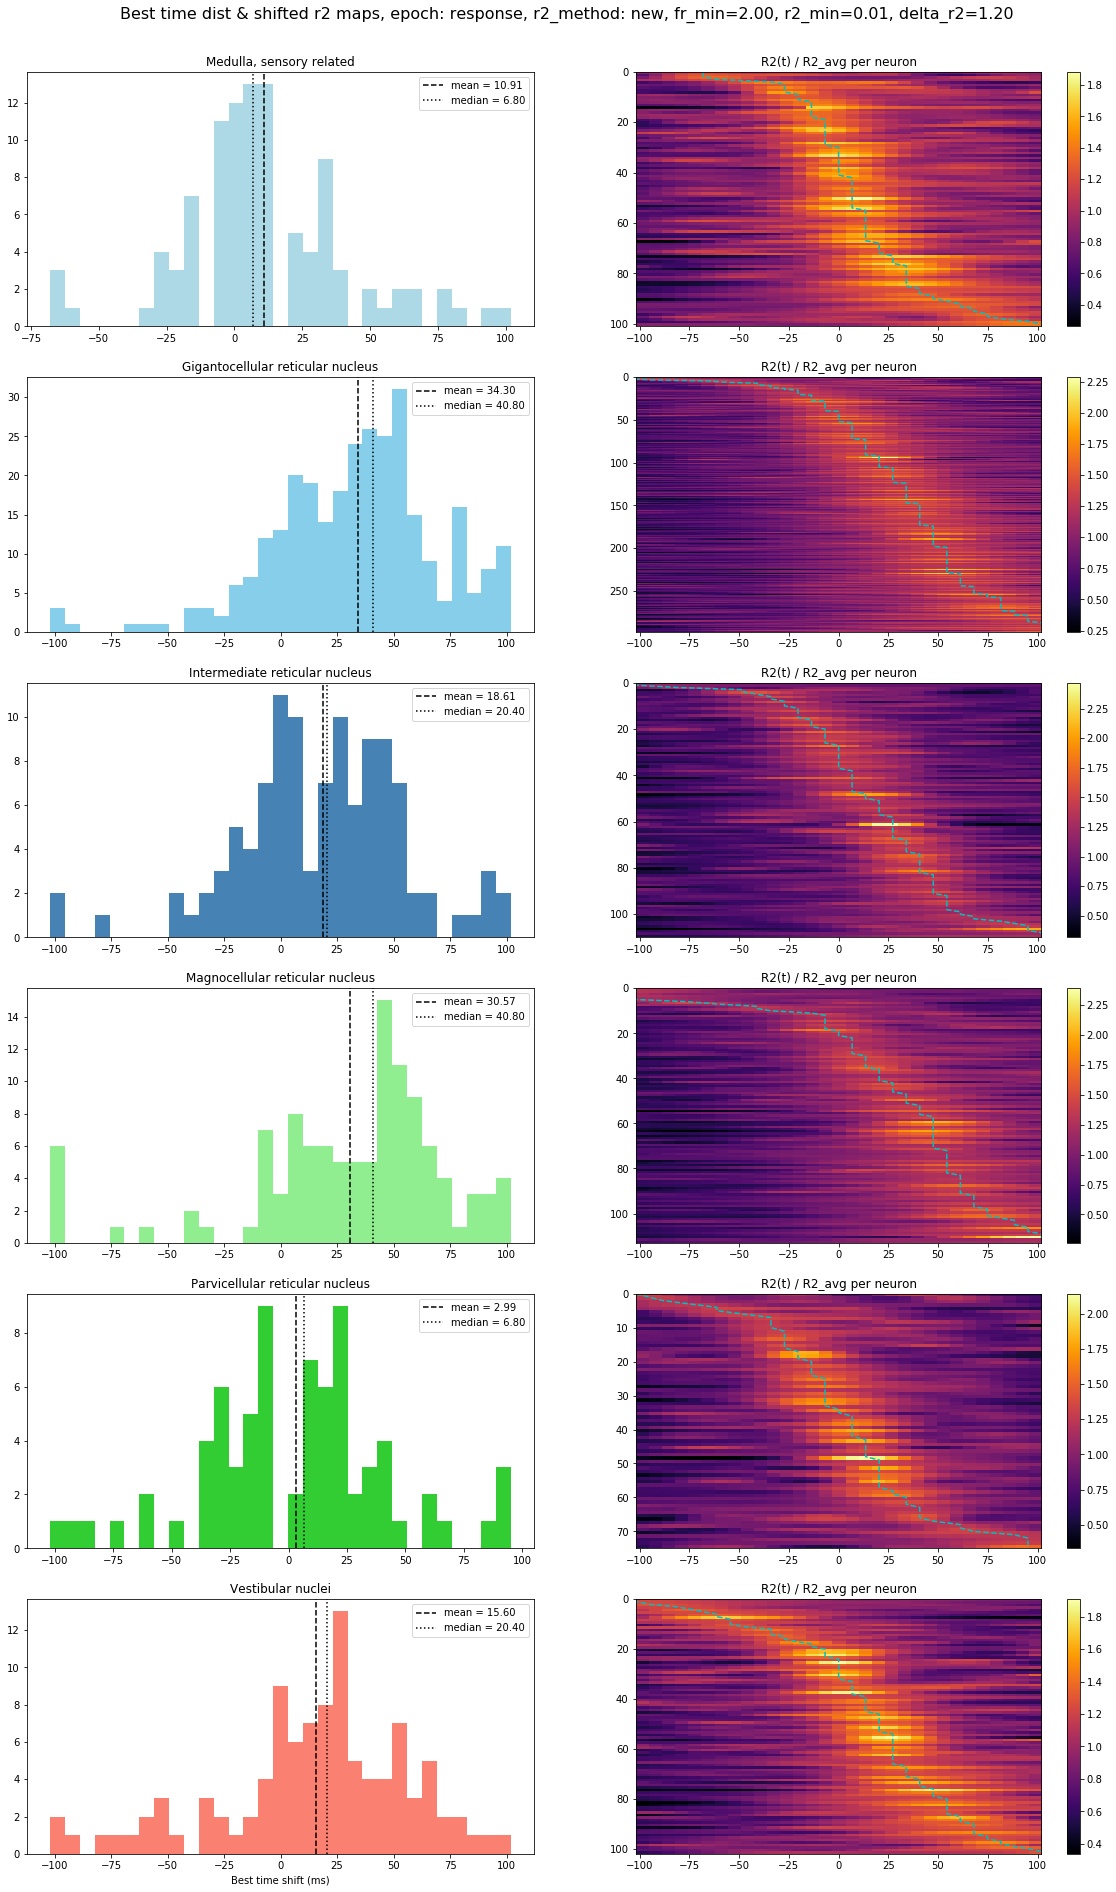

In [76]:
delta_r2 = 1.2

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    _mean = best_times[_this_inds].mean()
    _meadian = np.median(best_times[_this_inds])
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    a,b = plt.ylim()
    plt.plot([_mean, _mean], [a,b], 'k--', label = 'mean = %.2f'%_mean)
    plt.plot([_meadian, _meadian], [a,b], 'k:', label = 'median = %.2f'%_meadian)
    plt.ylim(a,b)
    plt.title(area)
    plt.legend()
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'medulla_best_time_dist_and_r2_maps_%s_%s_frmin%.2f_r2min%.2f.png'%(epoch,r2_method,fr_threshold,r2_threshold), bbox_inches = 'tight')

#### Midbrain

In [77]:
use_midbrain_list = [
    'Midbrain, sensory related',
    'Substantia nigra, reticular part',
    'Midbrain reticular nucleus',
    'Superior colliculus, motor related',
    #'Periaqueductal gray',
    #'Cuneiform nucleus',
    'Red nucleus',
    'Pretectal region',
    'Substantia nigra, compact part',
    'Pedunculopontine nucleus',
]

short_midbrain_names = [
    'Sensory',
    'SNR',
    'Reticular',
    'SCM',
    #'PG',
    'Red',
    'Pretectal',
    'SNC',
    'Pendunculopontine',
]

color_list = [
    "gray",
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",
    "red",
    "coral"
]

In [78]:
region_list = use_midbrain_list
n_min = 80


inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
use_inds = {k: np.intersect1d(v,threshold_inds) for k,v in inds.items() if np.intersect1d(v,threshold_inds).shape[0] > n_min}

<ipython-input-79-f85353e0f693>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


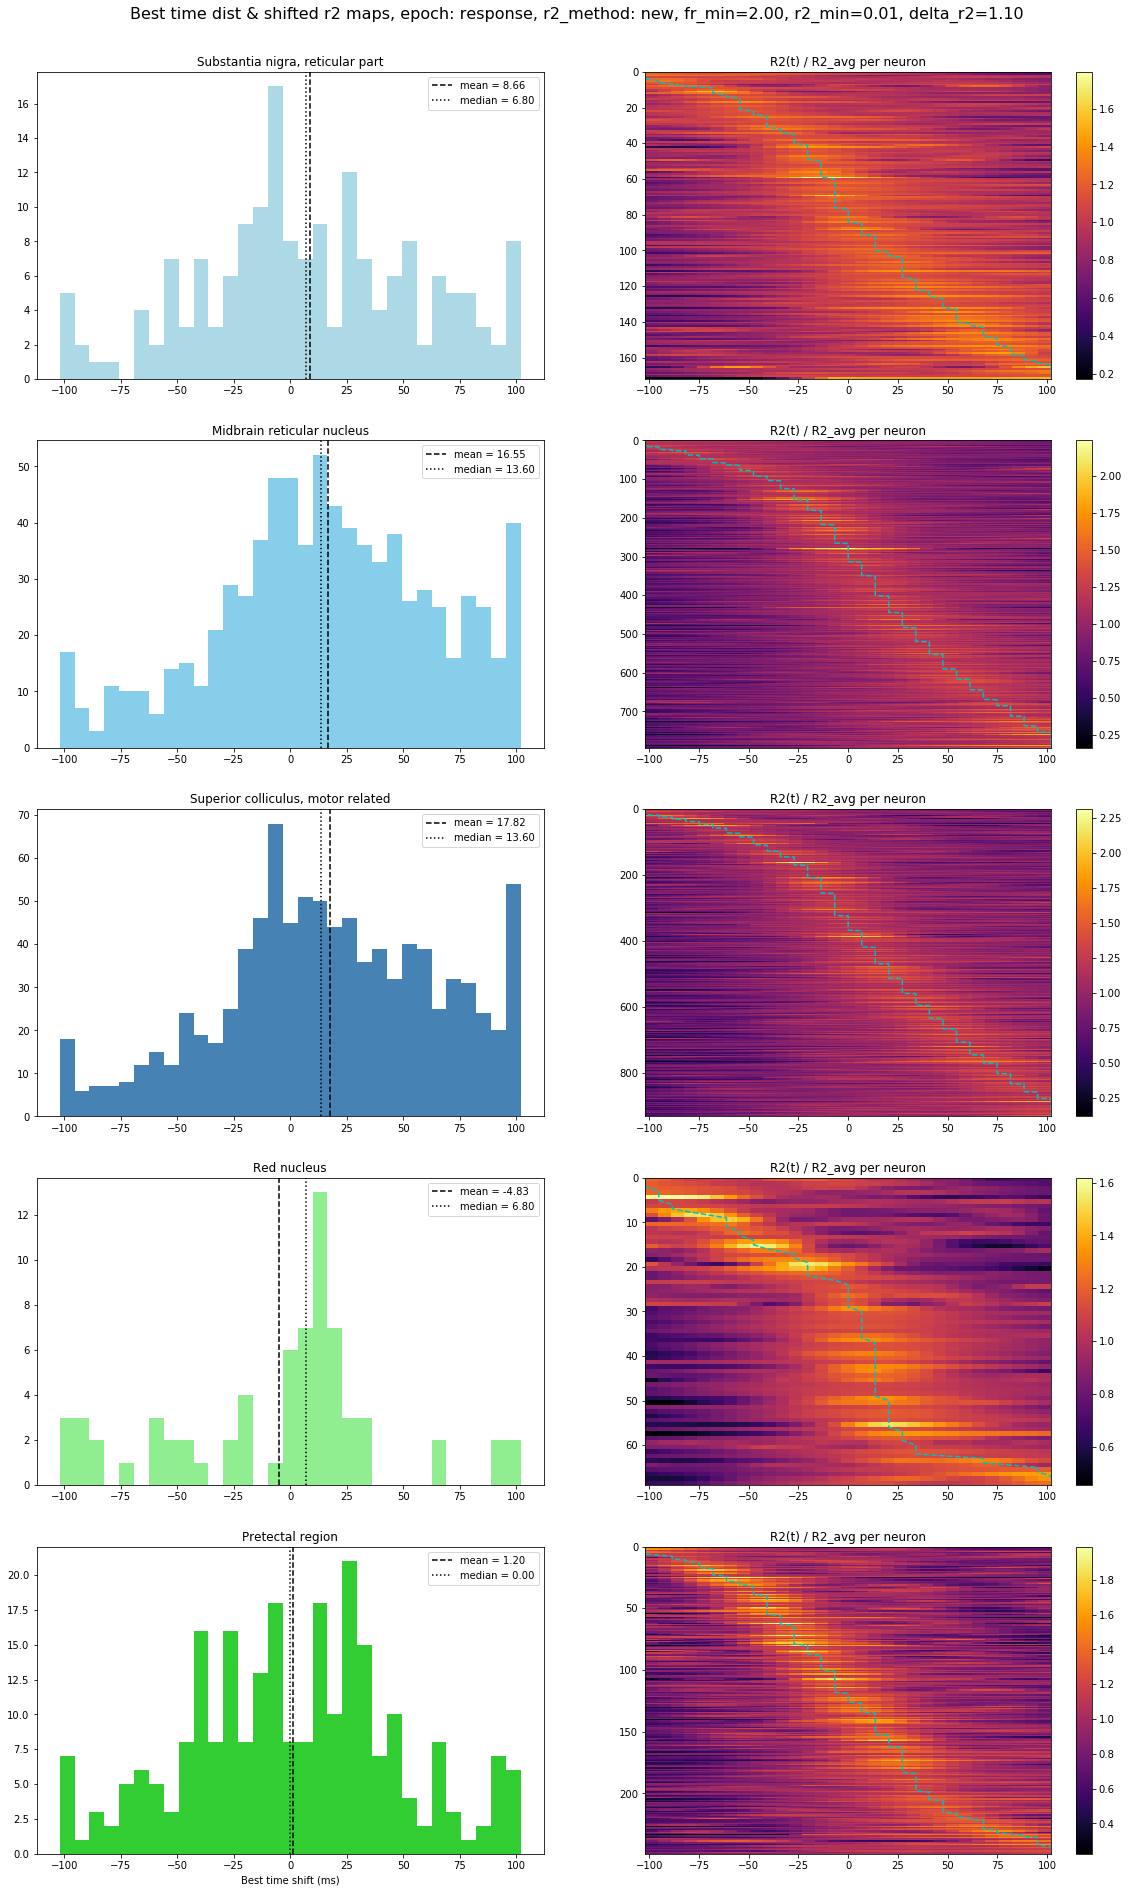

In [79]:
delta_r2 = 1.1

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    _mean = best_times[_this_inds].mean()
    _meadian = np.median(best_times[_this_inds])
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    a,b = plt.ylim()
    plt.plot([_mean, _mean], [a,b], 'k--', label = 'mean = %.2f'%_mean)
    plt.plot([_meadian, _meadian], [a,b], 'k:', label = 'median = %.2f'%_meadian)
    plt.ylim(a,b)
    plt.title(area)
    plt.legend()
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'midbrain_best_time_dist_and_r2_maps_%s_%s_frmin%.2f_r2min%.2f.png'%(epoch,r2_method,fr_threshold,r2_threshold), bbox_inches = 'tight')

#### Striatum

In [22]:
# Striatum

Striatum_subregions = func.get_n_layer_down_subregions_from_name(df, 'Striatum', 1)['region'].values
Striatum_subregions_annotations = {}
for subregion in Striatum_subregions:
    Striatum_subregions_annotations[subregion] = func.get_all_subregion_annotations_from_name(df, subregion)['region'].values
inds = func.get_neuron_inds_for_subregions(ccf_labels, Striatum_subregions_annotations)
medial_lateral_cutoff = 2500

dorsal_inds = {'Striatum dorsal region, medial': [], 'Striatum dorsal region, lateral': []}
for ii in inds['Striatum dorsal region']:
    ccf_x = ccf_coords[ii][0]
    if np.abs(ccf_x ) < medial_lateral_cutoff:
        dorsal_inds['Striatum dorsal region, medial'].append(ii)
    elif np.abs(ccf_x ) > medial_lateral_cutoff:
        dorsal_inds['Striatum dorsal region, lateral'].append(ii)

joint_inds = {}
for k in dorsal_inds.keys():
    joint_inds[k] = np.array(dorsal_inds[k])

for k in inds.keys():
    if k != 'Striatum dorsal region':
        joint_inds[k] = inds[k]

use_Striatum_nuclei = list(joint_inds.keys())

joint_color_list = ['grey', 'black', 'blue', 'green', 'yellow']
print(use_Striatum_nuclei)
striatum_short_names = [
    'Dorsal medial',
    'Dorsal lateral',
    'Ventral',
    'Lateral septal',
    'Str-like amyg'
]

['Striatum dorsal region, medial', 'Striatum dorsal region, lateral', 'Striatum ventral region', 'Lateral septal complex', 'Striatum-like amygdalar nuclei']


In [23]:
n_min = 110
use_inds = {k: np.intersect1d(v,threshold_inds) for k,v in joint_inds.items() if np.intersect1d(v,threshold_inds).shape[0] > n_min}

<ipython-input-24-d4d22ca648de>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


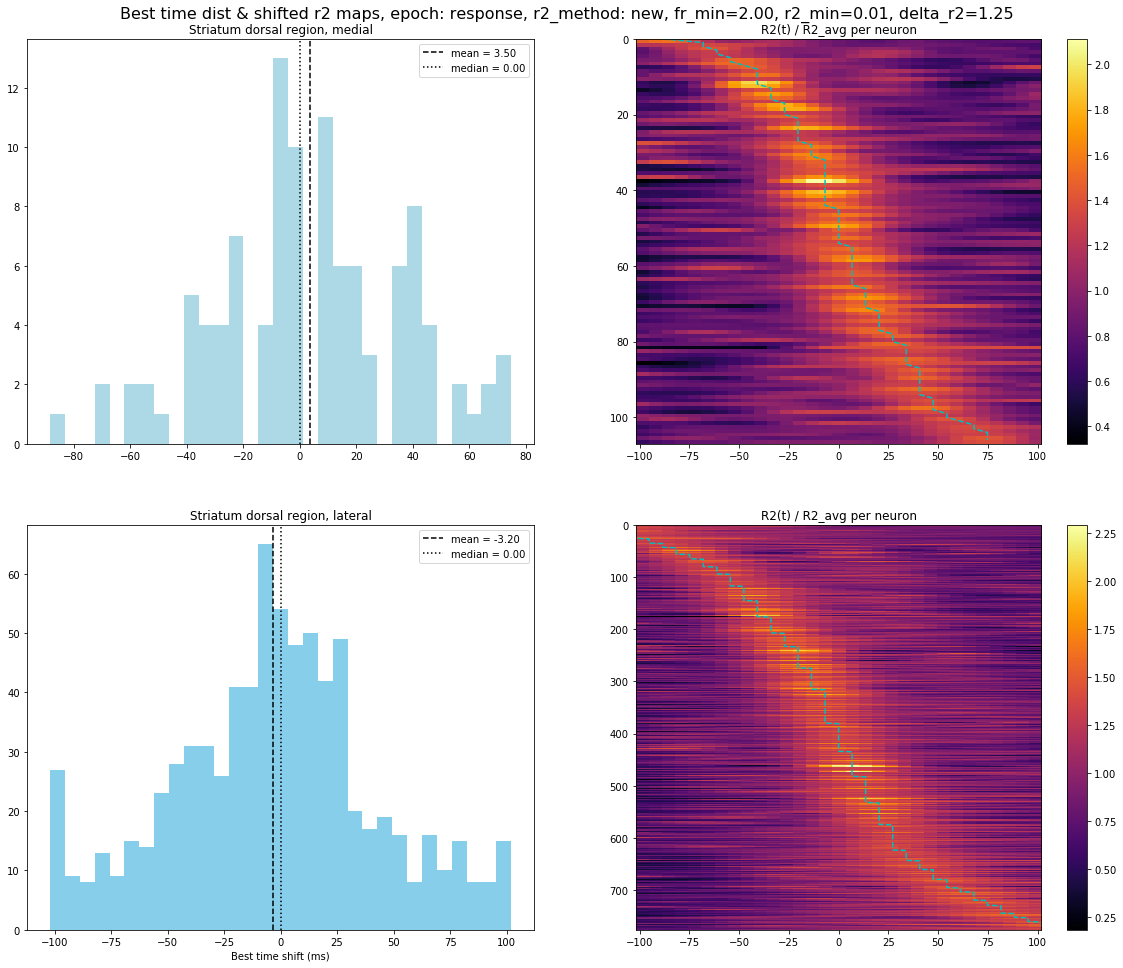

In [24]:
delta_r2 = 1.25

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,15))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    _mean = best_times[_this_inds].mean()
    _median = np.median(best_times[_this_inds])
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    a,b = plt.ylim()
    plt.plot([_mean, _mean], [a,b], 'k--', label = 'mean = %.2f'%_mean)
    plt.plot([_median, _median], [a,b], 'k:', label = 'median = %.2f'%_median)
    plt.ylim(a,b)
    plt.title(area)
    plt.legend()
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'striatum_best_time_dist_and_r2_maps_%s_%s_frmin%.2f_r2min%.2f.png'%(epoch,r2_method,fr_threshold,r2_threshold), bbox_inches = 'tight')

### Spatial maps

In [25]:
from matplotlib.colors import LinearSegmentedColormap
def get_2D_grid_averages_with_count(best_times, ccf_coords, voxel_size = 300, projection_axis = 0):
    # Project ccf_coords onto the 2D plane
    coords_2d = np.delete(ccf_coords, projection_axis, axis=1)
    
    # Calculate the voxel indices for each point
    voxel_indices = np.floor(coords_2d / voxel_size).astype(int)
    
    # Find the bounds for the grid
    min_indices = np.min(voxel_indices, axis=0)
    max_indices = np.max(voxel_indices, axis=0)
    grid_shape = max_indices - min_indices + 1
    
    # Initialize a grid to store the sum and count of best_times for averaging
    sum_grid = np.zeros(grid_shape)
    count_grid = np.zeros(grid_shape)
    
    # Populate the grids with summed times and counts
    for index, time in zip(voxel_indices, best_times):
        normalized_index = tuple(index - min_indices)  # Normalize indices to start from 0,0
        sum_grid[normalized_index] += time
        count_grid[normalized_index] += 1
    
    # Calculate the average best time for each voxel
    with np.errstate(invalid='ignore'):  # Ignore divisions by 0
        avg_grid = np.divide(sum_grid, count_grid)
        avg_grid[np.isnan(avg_grid)] = 0  # Replace NaNs with 0
    
    return avg_grid, min_indices, max_indices, count_grid

In [26]:
colors = [(0, 0, 1), (1, 1, 1), (1, 1, 0), (1, 0, 0)]  # Blue -> White -> Yellow -> Red
positions = [-50, 0, 50, 100]

# Normalize positions to the range [0, 1]
norm_positions = [(pos - positions[0]) / (positions[-1] - positions[0]) for pos in positions]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_positions, colors)))

In [27]:
delta_r2 = 1.20
fr_threshold = 2.
r2_threshold = 0.01



delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
restriction_inds = np.intersect1d(threshold_inds, delta_inds)

<ipython-input-27-4e816d519028>:7: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


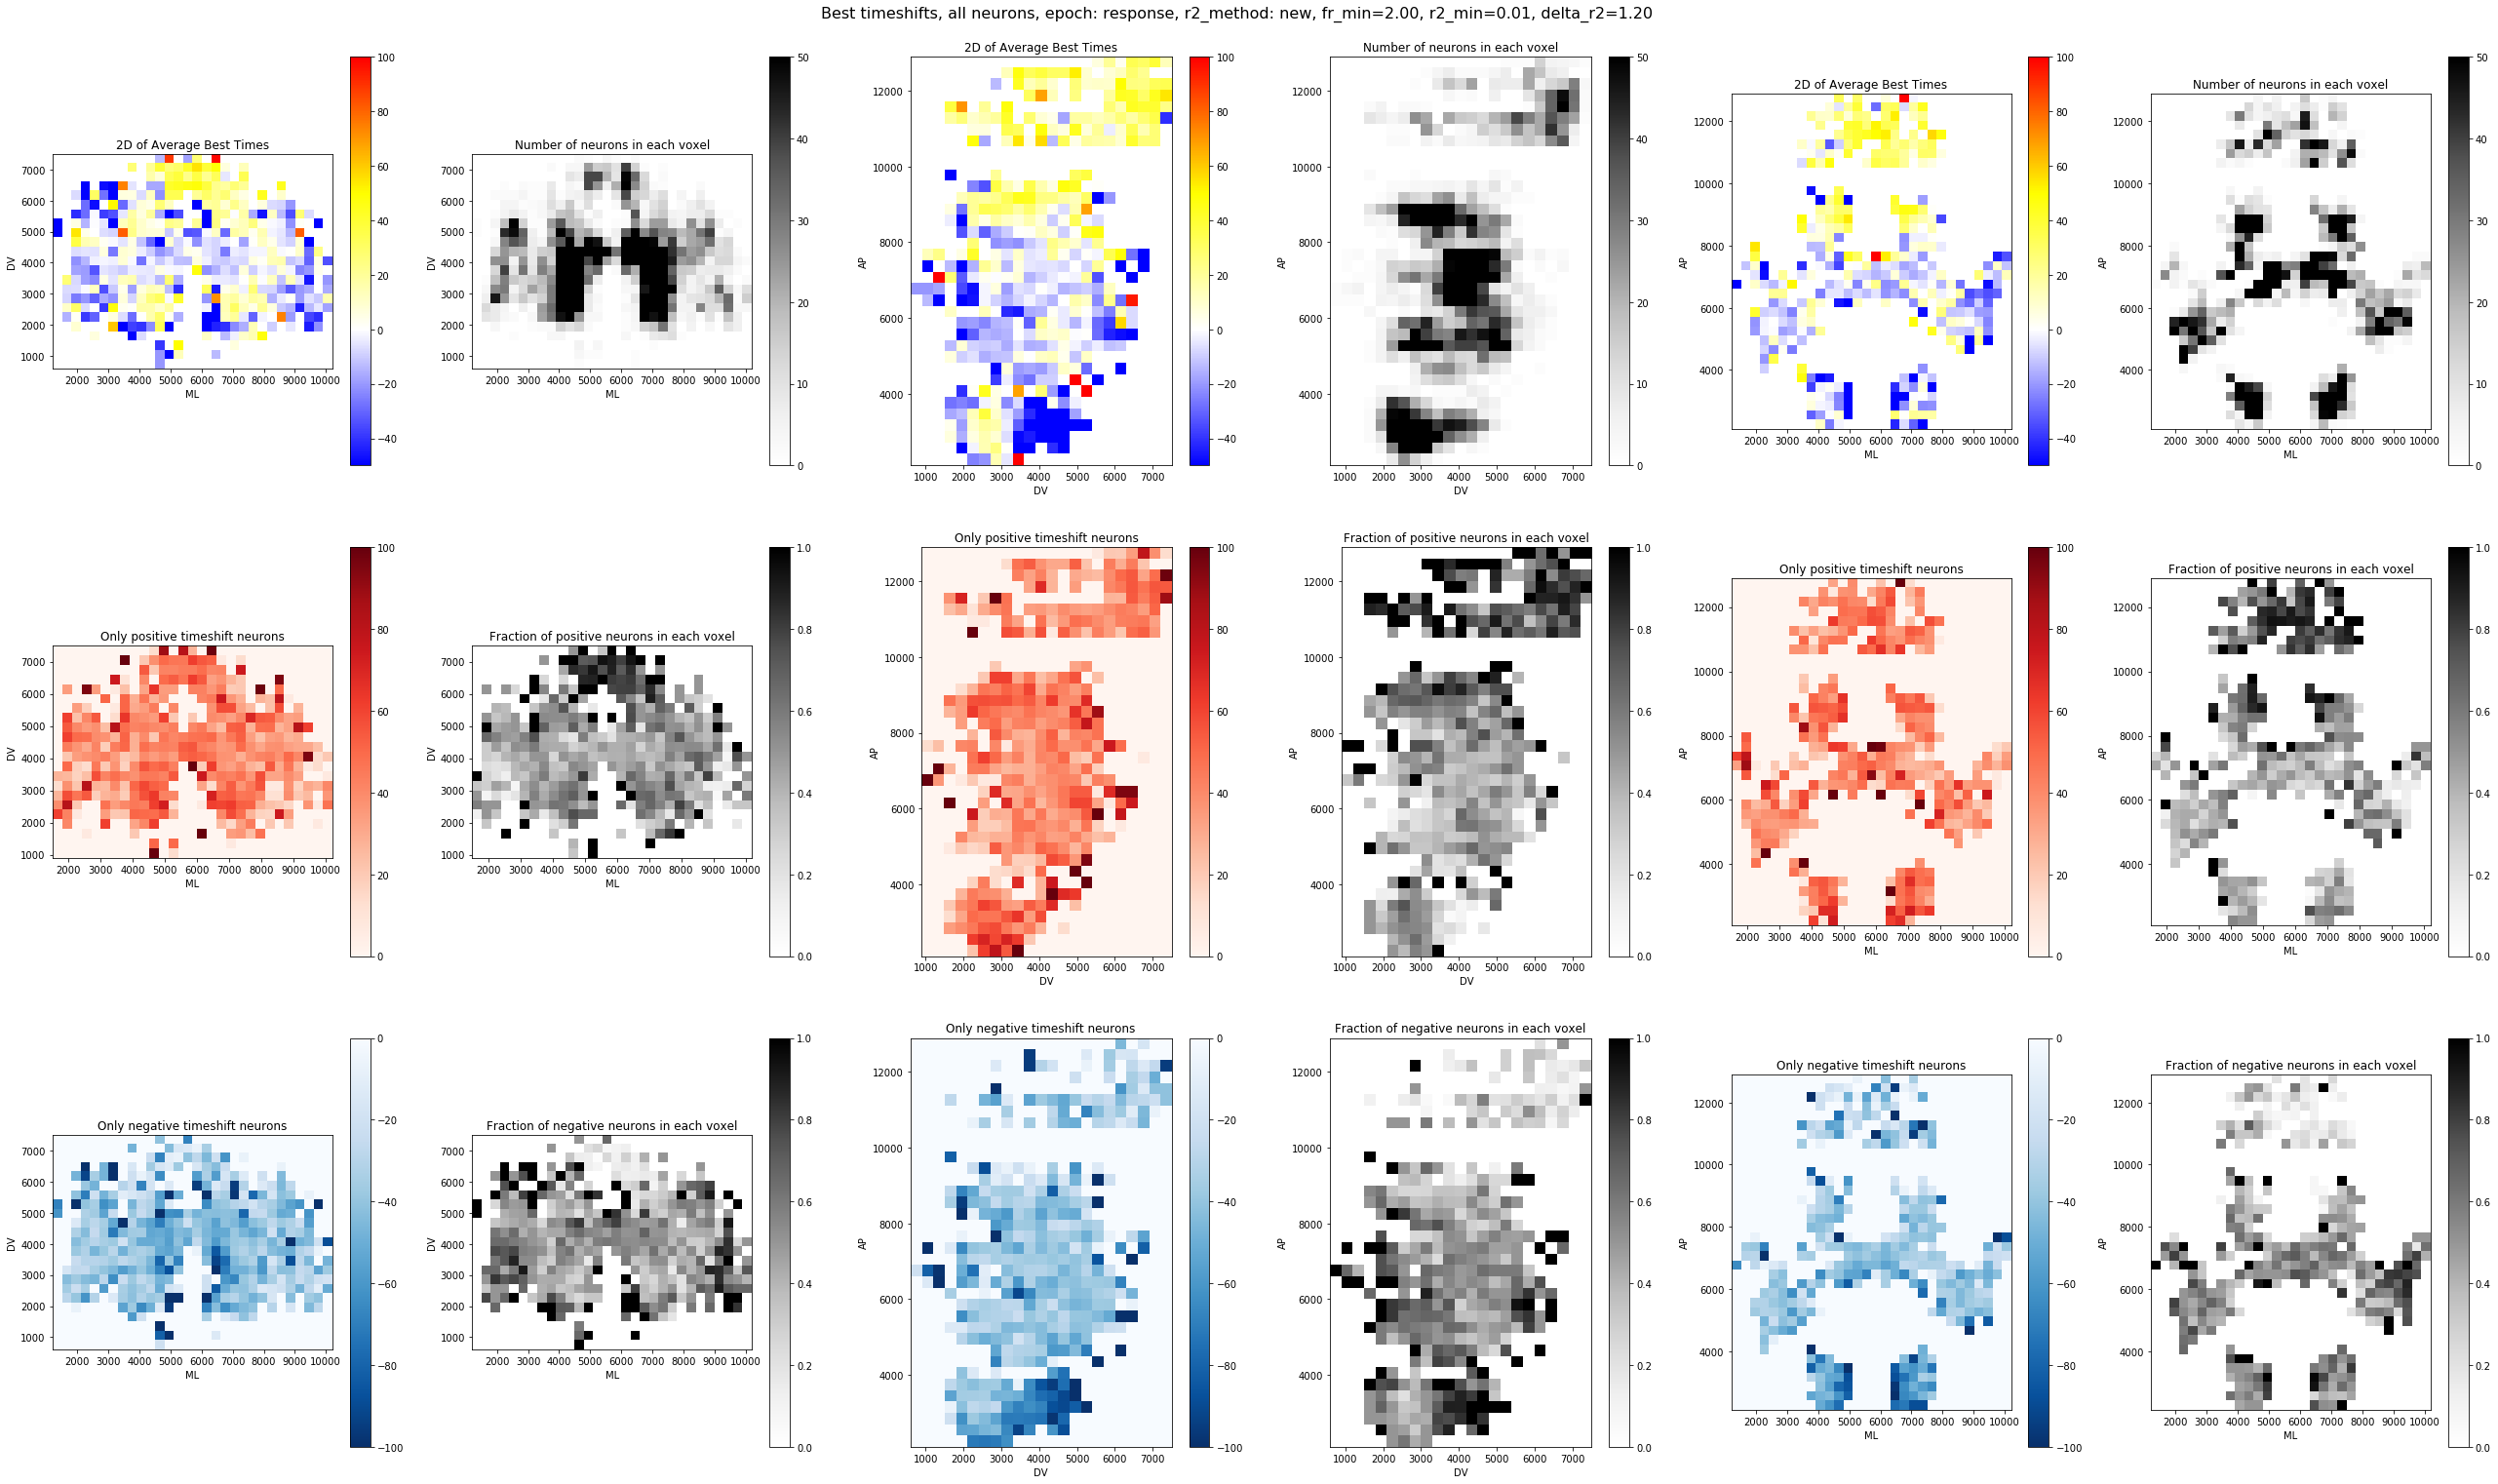

In [28]:
f,_ = plt.subplots(3,6, figsize = (45,24))

f.suptitle('Best timeshifts, all neurons, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold,delta_r2), fontsize = 16)

# Define voxel size for the 2D plane
voxel_size = 300
avg_grid, min_indices_2, max_indices_2, grid_count_2 = get_2D_grid_averages_with_count(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 2)


plt.subplot(3,6,1)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices_2[0]*voxel_size, (max_indices_2[0]+1)*voxel_size, min_indices_2[1]*voxel_size, (max_indices_2[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('2D of Average Best Times')

plt.subplot(3,6,2)
plt.imshow(grid_count_2.T,origin='lower', cmap='Greys', vmin = 0,vmax = 50, extent=[min_indices_2[0]*voxel_size, (max_indices_2[0]+1)*voxel_size, min_indices_2[1]*voxel_size, (max_indices_2[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Number of neurons in each voxel')

avg_grid, min_indices_0, max_indices_0, grid_count_0 = get_2D_grid_averages_with_count(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 0)


plt.subplot(3,6,3)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices_0[0]*voxel_size, (max_indices_0[0]+1)*voxel_size, min_indices_0[1]*voxel_size, (max_indices_0[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

plt.subplot(3,6,4)
plt.imshow(grid_count_0.T,origin='lower', cmap='Greys', vmin = 0,vmax = 50, extent=[min_indices_0[0]*voxel_size, (max_indices_0[0]+1)*voxel_size, min_indices_0[1]*voxel_size, (max_indices_0[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Number of neurons in each voxel')

avg_grid, min_indices_1, max_indices_1, grid_count_1 = get_2D_grid_averages_with_count(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 1)


plt.subplot(3,6,5)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices_1[0]*voxel_size, (max_indices_1[0]+1)*voxel_size, min_indices_1[1]*voxel_size, (max_indices_1[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

plt.subplot(3,6,6)
plt.imshow(grid_count_1.T,origin='lower', cmap='Greys', vmin = 0,vmax = 50, extent=[min_indices_1[0]*voxel_size, (max_indices_1[0]+1)*voxel_size, min_indices_1[1]*voxel_size, (max_indices_1[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Number of neurons in each voxel')

pos_inds = np.where(best_times[restriction_inds] > 0)[0]

avg_grid, min_indices_2p, max_indices_2p,grid_count_2_p = get_2D_grid_averages_with_count(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 2)


plt.subplot(3,6,7)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices_2p[0]*voxel_size, (max_indices_2p[0]+1)*voxel_size, min_indices_2p[1]*voxel_size, (max_indices_2p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Only positive timeshift neurons')

plt.subplot(3,6,8)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_2_p, grid_count_2[min_indices_2p[0]-min_indices_2[0]:,min_indices_2p[1]-min_indices_2[1]:])
    frac_pos[np.isnan(avg_grid)] = 0
plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_2p[0]*voxel_size, (max_indices_2p[0]+1)*voxel_size, min_indices_2p[1]*voxel_size, (max_indices_2p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Fraction of positive neurons in each voxel')

avg_grid, min_indices_0p, max_indices_0p, grid_count_0_p = get_2D_grid_averages_with_count(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 0)


plt.subplot(3,6,9)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices_0p[0]*voxel_size, (max_indices_0p[0]+1)*voxel_size, min_indices_0p[1]*voxel_size, (max_indices_0p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Only positive timeshift neurons')

plt.subplot(3,6,10)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_0_p, grid_count_0[min_indices_0p[0]-min_indices_0[0]:,min_indices_0p[1]-min_indices_0[1]:])
    frac_pos[np.isnan(avg_grid)] = 0

plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_0p[0]*voxel_size, (max_indices_0p[0]+1)*voxel_size, min_indices_0p[1]*voxel_size, (max_indices_0p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Fraction of positive neurons in each voxel')

avg_grid, min_indices_1p, max_indices_1p, grid_count_1_p = get_2D_grid_averages_with_count(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 1)


plt.subplot(3,6,11)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices_1p[0]*voxel_size, (max_indices_1p[0]+1)*voxel_size, min_indices_1p[1]*voxel_size, (max_indices_1p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Only positive timeshift neurons')

plt.subplot(3,6,12)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_1_p, grid_count_1[min_indices_1p[0]-min_indices_1[0]:,min_indices_1p[1]-min_indices_1[1]:])
    frac_pos[np.isnan(avg_grid)] = 0

plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_1p[0]*voxel_size, (max_indices_1p[0]+1)*voxel_size, min_indices_1p[1]*voxel_size, (max_indices_1p[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Fraction of positive neurons in each voxel')

neg_inds = np.where(best_times[restriction_inds] < 0)[0]
avg_grid, min_indices_2n, max_indices_2n, grid_count_2_n = get_2D_grid_averages_with_count(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 2)


plt.subplot(3,6,13)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices_2n[0]*voxel_size, (max_indices_2n[0]+1)*voxel_size, min_indices_2n[1]*voxel_size, (max_indices_2n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Only negative timeshift neurons')

plt.subplot(3,6,14)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_2_n, grid_count_2[min_indices_2n[0]-min_indices_2[0]:,min_indices_2n[1]-min_indices_2[1]:])
    frac_pos[np.isnan(avg_grid)] = 0

plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_2n[0]*voxel_size, (max_indices_2n[0]+1)*voxel_size, min_indices_2n[1]*voxel_size, (max_indices_2n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Fraction of negative neurons in each voxel')

avg_grid, min_indices_0n, max_indices_0n, grid_count_0_n = get_2D_grid_averages_with_count(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 0)


plt.subplot(3,6,15)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices_0n[0]*voxel_size, (max_indices_0n[0]+1)*voxel_size, min_indices_0n[1]*voxel_size, (max_indices_0n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Only negative timeshift neurons')

plt.subplot(3,6,16)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_0_n, grid_count_0[min_indices_0n[0]-min_indices_0[0]:,min_indices_0n[1]-min_indices_0[1]:])
    frac_pos[np.isnan(avg_grid)] = 0
plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_0n[0]*voxel_size, (max_indices_0n[0]+1)*voxel_size, min_indices_0n[1]*voxel_size, (max_indices_0n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('Fraction of negative neurons in each voxel')

avg_grid, min_indices_1n, max_indices_1n,grid_count_1_n = get_2D_grid_averages_with_count(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 1)


plt.subplot(3,6,17)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices_1n[0]*voxel_size, (max_indices_1n[0]+1)*voxel_size, min_indices_1n[1]*voxel_size, (max_indices_1n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Only negative timeshift neurons')

plt.subplot(3,6,18)
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    frac_pos = np.divide(grid_count_1_n, grid_count_1[min_indices_1n[0]-min_indices_1[0]:,min_indices_1n[1]-min_indices_1[1]:])
    frac_pos[np.isnan(avg_grid)] = 0
plt.imshow(frac_pos.T,origin='lower', cmap='Greys', vmin = 0,vmax = 1, extent=[min_indices_1n[0]*voxel_size, (max_indices_1n[0]+1)*voxel_size, min_indices_1n[1]*voxel_size, (max_indices_1n[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('Fraction of negative neurons in each voxel')

plt.subplots_adjust(top = 0.95)
plt.savefig(figfolder + 'best_times_spatial_distributions_all_pos_neg_with_fraction.png', bbox_inches='tight')


In [ ]:
avg_grid, min_indices_2, max_indices_2, grid_count_2 = get_2D_grid_averages_with_count(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 2)


plt.subplot(3,6,1)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices_2[0]*voxel_size, (max_indices_2[0]+1)*voxel_size, min_indices_2[1]*voxel_size, (max_indices_2[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('2D of Average Best Times')

plt.subplot(3,6,2)
plt.imshow(grid_count_2.T,origin='lower', cmap='Greys', vmin = 0,vmax = 50, extent=[min_indices_2[0]*voxel_size, (max_indices_2[0]+1)*voxel_size, min_indices_2[1]*voxel_size, (max_indices_2[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('Number of neurons in each voxel')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Setup for subplots
fig, axs = plt.subplots(3, 6, figsize=(45, 24))

# Voxel size definition
voxel_size = 300

# Data and axis projection configurations
data_configs = [
    (2, 'Average Best Times', 'ML', 'DV', custom_cmap, -50, 100),
    (2, 'Number of neurons in each voxel', 'ML', 'DV', 'Greys', 0, 50),
    (0, 'Average Best Times', 'DV', 'AP', custom_cmap, -50, 100),
    (0, 'Number of neurons in each voxel', 'DV', 'AP', 'Greys', 0, 50),
    (1, 'Average Best Times', 'ML', 'AP', custom_cmap, -50, 100),
    (1, 'Number of neurons in each voxel', 'ML', 'AP', 'Greys', 0, 50),
    # Add more configurations as needed
]

# Function to handle repetitive plotting logic
def plot_data(ax, data, cmap, vmin, vmax, labels, title):
    ax.imshow(data.T, origin='lower', interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
    ax.colorbar()
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title(title)

# Loop over each configuration and plot
for i, config in enumerate(data_configs):
    projection_axis, title, xlabel, ylabel, cmap, vmin, vmax = config
    ax = axs[i // 6, i % 6]
    
    # Adjust these function calls as necessary to match your data retrieval logic
    avg_grid, min_indices, max_indices, grid_count = get_2D_grid_averages_with_count(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis=projection_axis)
    
    # Use different logic/data for "fraction of positive/negative neurons" plots
    if title.startswith("Fraction of"):
        with np.errstate(invalid='ignore'):  # Handle divisions by 0
            data = np.divide(grid_count_p, grid_count)
            data[np.isnan(avg_grid)] = 0  # Adjust this as necessary
    else:
        data = avg_grid if title != "Number of neurons in each voxel" else grid_count
    
    plot_data(ax, data, cmap, vmin, vmax, (xlabel, ylabel), title)

# Additional plots for positive/negative timeshift neurons with special handling can be added similarly

plt.savefig(figfolder + 'best_times_spatial_distributions_all_pos_neg_with_fraction.pdf', bbox_inches='tight')
